[Our paper](https://arxiv.org/pdf/1910.12478.pdf) shows that Gaussian process behavior occurs for any architecture with independently sampled output layer weights, as long as their width is large.
We explore this phenomenon in *Bidirectional RNNs* in this notebook, give reference implementations of the computation of the theoretical Bidirectional RNN kernel, and show that indeed, the empirical kernels concentrate around this theoretical kernel as the width gets large.

This notebook is self-contained, and does not require reading other notebooks in this repo.

Note: The Bidirectional RNN is not a part of the original paper, but is shown here as an example extending the paper. The calculations are shown in an intuitive way, but can be proven with more rigor.

# Setup

In [1]:
import numpy as np
import scipy.special as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
sent1 = "The brown fox jumps over the dog".split()
sent2 = "The quick brown fox jumps over the lazy dog".split()

In the next cell, we load the GloVe vectors and their covariances that come with this repo.
They were generated by [GloVe.ipynb](GloVe.ipynb) from the two sentences

```The brown fox jumps over the dog.```

```The quick brown fox jumps over the lazy dog.```

Concretely, `exampleGloveVecs[:7]` contains the GloVe embeddings of the words from the first sentence, and `exampleGloveVecs[7:16]` contains those of the second sentence.

Likewise, `exampleGloveCov` is a 16x16 matrix, such that `exampleGloveCov[:7, :7]` gives the autocovariance of the GloVe embeddings of the first sentence, `exampleGloveCov[7:, 7:]` gives that of the second sentence, and `exampleGloveCov[:7, 7:]` gives the covariance between those of the first and those of the second sentence.

In [3]:
with open('ExampleGloVeVecs.npy', 'rb') as f:
    exampleGloveVecs = np.load(f)
with open('ExampleGloVeCov.npy', 'rb') as f:
    exampleGloveCov = np.load(f)

#  Bidirectional RNN

A bidirectional RNN with scalar output at every time step evolves like
$$
\begin{align*}
h^t_f &= W s^{t-1}_f + U x^{t}_f + b\\
s^t_f &= \phi(h^t_f)\\

h^t_b &= W s^{t-1}_b + U x^{t}_b + b\\
s^t_b &= \phi(h^t_b)\\
\end{align*}
$$

where

- $x^t_f \in \mathbb{R}^m$ is the input at time $t$ for forward inputs
- $x^t_b \in \mathbb{R}^m$ is the input at time $t$ for backward inputs
- $h^t_f \in \mathbb{R}^n$ is the pre-activation at time $t$ for forward inputs
- $h^t_b \in \mathbb{R}^n$ is the pre-activation at time $t$ for backward inputs
- $s^t_f \in \mathbb{R}^n$ is the state of the RNN at time $t$ for forward inputs
- $s^t_b \in \mathbb{R}^n$ is the state of the RNN at time $t$ for backward inputs
- $W \in \mathbb{R}^{n \times n}$ is the state-to-state weight matrix
- $U \in \mathbb{R}^{n \times m}$ is the input-to-state weight matrix
- $b \in \mathbb{R}^n$ is the bias
- $\phi$ is the nonlinearity

Simultaneously, two RNNs evolve with the same equations, but with the second using the input backwards. The two RNNs do not interact while calculating their output on each timestep independently.

The final output can then be a variety of combinations of the two states of the RNNs. For this notebook, concatenation and summation. Concatenation is described as:

$$
\begin{align*}
        y^t &= \langle v, \frac{(s^t_f, s^t_b)}{\sqrt{2n}}\rangle
\end{align*}
$$


where 

- $v \in \mathbb{R}^{2n}$ is the readout weight
- $y^t \in \mathbb{R}$ is the output at time t

and the output is over $\sqrt{2n}$ because the output width has been doubled due to concatenation.

Summation can then be described as 



$$
\begin{align*}
        y^t &= \langle v, \frac{s^t_f + s^t_b}{\sqrt{n}}\rangle
\end{align*}
$$

    
Typically, $\phi = \tanh$, but here, we will set $\phi = \mathrm{erf}$ because $\mathrm{erf}$ is very similar to $\tanh$ and it gives way to closed form expressions for the infinite-width limit.

# NETSOR Representation of Bidirectional RNN Computation

[Our paper](https://arxiv.org/pdf/1910.12478.pdf) shows the universality of Gaussian process behavior roughly in two steps: 1) Any neural network architecture (more specifically, its computation on some inputs) can be expressed via a simple language called NETSOR, and 2) we show that the Gaussian process behavior occurs in any NETSOR program with large "width" by an inductive argument on the program structure.

## The "Infinite-Width" Limit of NETSOR Programs

The Gaussian process behavior of a NETSOR program is a consequence of the NETSOR Master Theorem, which roughly prescribes the following rules for deriving the "behavior" of vectors in the program, when input matrices (denoted $\mathsf{A}(n, n)$ above, of shape $n \times n$) are sampled like $\mathcal{N}(0, 1/n)$:

- If a vector $y$ is a result of matrix multiplication $y = A x$, then $y$ can be thought of as a vector with iid Gaussian coordinates when $n \to \infty$.
- If another vector $y'$ is also obtained by matrix multiplication $y' = A x'$, then each coordinate slice of $(y, y')$, i.e. $(y_\alpha, y'_\alpha)$ for each $\alpha \in [n]$, can be thought of as jointly Gaussian, iid in $\alpha$. This joint Gaussian distribution is $$\mathcal{N}\left(0, \frac{1}{n} \begin{pmatrix}\|x\|^2 & \langle x, x'\rangle\\ \langle x, x' \rangle & \|x'\|^2 \end{pmatrix}\right).$$
- If $y'$ is instead obtained from matrix multiplication by a different (independently sampled) matrix $B$ from $A$, $y' = B x'$, then $y$ and $y'$ can be thought of as independent.
- Similarly, if $y'$ is an input vector, not generated by matrix multiplication, then $y$ can also be thought of as independent from $y'$.

*Note that these intuitive rules no longer hold if both a matrix $A$ and its transpose $A^\top$ appear in a program! But in the version of NETSOR used here, this will not happen.*

These rough rules will be the extent we discuss the Master Theorem here. 
See [the paper](https://arxiv.org/pdf/1910.12478.pdf) for a more formal treatment.

# Theory: Infinite-width Kernel of Bidirectional RNN Embeddings

In this section we derive the formula for computing the Bidirectional RNN kernel. 

If you are not interested in seeing the derivation, go straight to the next code cell.

By the NETSOR Master Theorem (and as we argue intuitively below), the normalized inner products $\langle s^t, s^r \rangle / n$ for any two time steps $t$ and $r$ will converge almost surely to a deterministic value.
Suppose we sample $v_\alpha \sim \mathcal{N}(0, 1 / n)$.
The outputs $y^t$ and $y^r$ will then be jointly Gaussian with covariance given by this limit.
Thus computing the distribution of $y^t$ reduces to computing the almost sure limits of $\langle s^t, s^r \rangle / n$ for all pairs $t, r$.

## Correlation between $h^i$ and $h^j$ in a simple RNN

First, we will examine a simple RNN, which will be used as part of the process of calculating the GP for a Bidirectional RNN.

For simplicity, suppose we sample $b_\alpha \sim \mathcal{N}(0, 0) = 0$ and
- $W_{\alpha \beta} \sim \mathcal{N}(0, 1 / n)$
- $U_{\alpha \beta} \sim \mathcal{N}(0, 1 / m)$

Then, according to the intuitive rules from the NETSOR Master Theorem we laid out in [Section 2.2](#The-"Infinite-Width"-Limit-of-NETSOR-Programs):
- For any time $t$, the $\alpha$-slice $\{(W s^1)_\alpha, \ldots, (W s^t)_\alpha\}$ is distributed jointly as a multivariate Gaussian, iid for each $\alpha$
- For any time $t$, the $\alpha$-slice $\{(U x^1)_\alpha, \ldots, (U x^t)_\alpha\}$ is distributed jointly as a multivariate Gaussian, iid for each $\alpha$
- Vectors of the form $W s^t$ can be thought to be "independent" from vectors of the form $U x^s$
- Consequently, for any time $t$, the $\alpha$-slice $\{h^1_\alpha, \ldots, h^t_\alpha\}$, as the sum of the slices $\{(W s^1)_\alpha, \ldots, (W s^t)_\alpha\}$ and $\{(U x^1)_\alpha, \ldots, (U x^t)_\alpha\}$, is distributed jointly as a Gaussian, iid for each $\alpha$

Let us write $\Sigma(W s^i, W s^j)$ for the covariance between $(Ws^i)_\alpha$ and $(Ws^j)_\alpha$; likewise for $\Sigma(U x^i, U x^j)$ and $\Sigma(h^i, h^j)$.
Then by the rules in [Section 2.2](#The-"Infinite-Width"-Limit-of-NETSOR-Programs), we have
$$
\begin{align*}
\Sigma(h^i, h^j)
    &=
        \Sigma(W s^{i-1}, Ws^{j-1}) + \Sigma(U x^i, U x^j)
\end{align*}
$$
because $W$ and $U$ are independently sampled.

By some straightforward (rigorous) calculation, $\Sigma(U x^i, U x^j) = \langle x^i, x^j \rangle/m$.
Furthermore, by [Section 2.2](#The-"Infinite-Width"-Limit-of-NETSOR-Programs), roughly speaking
$$
\begin{align*}
\Sigma(W s^{i-1}, W s^{j-1})
    &\approx
        \langle s^{i-1}, s^{j-1} \rangle /n
\end{align*}
$$
for large $n$.

But since $s^{i-1} = \phi(h^{i-1})$ and $s^{j-1} = \phi(h^{j-1})$, and since we are thinking of $h^{i-1}$ and $h^{j-1}$ as having iid coordinates, intuitively we should have
$$
\begin{align*}
\langle s^{i-1}, s^{j-1} \rangle /n
    &=
        \frac 1 n \sum_{\alpha=1}^n s^{i-1}_\alpha s^{j-1}_\alpha
        \\
    &=
        \frac 1 n \sum_{\alpha=1}^n \phi(h^{i-1}_\alpha) \phi(h^{j-1}_\alpha)
        \\
    &\approx
        {\mathbb{E}} \phi(z_1)\phi(z_2)
\end{align*}
$$
where $(z_1, z_2) \sim \mathcal{N}\left( 0,
\Sigma|^h_{\{i-1,j-1\}}
\right)
$ and $\Sigma|^h_{\{i-1,j-1\}} = \begin{pmatrix}
\Sigma(h^{i-1}, h^{i-1}) & \Sigma(h^{i-1}, h^{j-1})\\
\Sigma(h^{j-1}, h^{i-1}) & \Sigma(h^{j-1}, h^{j-1})
\end{pmatrix}$.

All of the above reasoning, turns out, can be made rigorous, and we have a recurrence relation
$$
\Sigma(h^i, h^j) = {\mathbb{E}} \phi(z_1)\phi(z_2) + \langle x^i, x^j \rangle /m
$$
where $(z_1, z_2) \sim \mathcal{N}\left( 0,
\Sigma|^h_{\{i-1,j-1\}}
\right)$.

If $\phi  = \mathrm{erf}$, for example, then by a well-known formula
$${\mathbb{E}} \phi(z_1)\phi(z_2) = \arcsin \frac{\Sigma(h^{i-1}, h^{j-1})}{\sqrt{(\Sigma(h^{i-1}, h^{i-1}) + 1/2)(\Sigma(h^{j-1}, h^{j-1}) + 1/2)}}
$$
and the recursion above can be computed efficiently.

More generally, if we sample $W_{\alpha \beta} \sim \mathcal{N}(0, \sigma_w^2 / n)$, $U_{\alpha \beta} \sim \mathcal{N}(0, \sigma_u^2 / m)$, and $b_\alpha \sim \mathcal{N}(0, \sigma_b^2)$, then the recurrence can be generalized to
$$
\Sigma(h^i, h^j) = \sigma_w^2 {\mathbb{E}} \phi(z_1)\phi(z_2) + \sigma_u^2 \langle x^i, x^j \rangle /m + \sigma_b^2.
$$

If there are multiple input sequences $\{x^{1a}, x^{2a}, \ldots, x^{ta}, \ldots\}_a$ for $a = 1, \ldots, k$, and we let $h^{ia}$ denote a state preactivation from the $a$th sequence at time $i$, then $h^{ia}$ and $h^{jb}$ will in general be correlated, and the above recursion can likewise be generalized to
$$
\Sigma(h^{ia}, h^{jb}) = \sigma_w^2 {\mathbb{E}} \phi(z_1)\phi(z_2) + \sigma_u^2 \langle x^{ia}, x^{jb} \rangle /m + \sigma_b^2
$$
where $(z_1, z_2) \sim \mathcal{N}\left(0,
\begin{pmatrix}
\Sigma(h^{i-1, a}, h^{i-1,a }) & \Sigma(h^{i-1, a}, h^{j-1, b})\\
\Sigma(h^{j-1, b}, h^{i-1, a}) & \Sigma(h^{j-1, b}, h^{j-1, b})
\end{pmatrix}
\right).$
Again, this intuitive argument can be made rigorous (see our paper).

## The RNN Output Distribution

Again, as $h^i$ can be thought to have iid coordinates, 
$$
\begin{align*}
\langle s^{i-1}, s^{j-1} \rangle /n
    &=
        \frac 1 n \sum_{\alpha=1}^n s^{i-1}_\alpha s^{j-1}_\alpha
        \\
    &=
        \frac 1 n \sum_{\alpha=1}^n \phi(h^{i-1}_\alpha) \phi(h^{j-1}_\alpha)
\end{align*}
$$
should converge to a deterministic quantity $K_{i-1, j-1}$ (computed in the previous section) as $n \to \infty$.
Then, with $v_\alpha \sim \mathcal{N}(0, 1/n)$, the distribution of $\{y^1, \ldots, y^t\}$ tends to the Gaussian
$$
\mathcal{N}\left(0,
\begin{pmatrix}
K_{11} & \cdots & K_{1t}\\
\vdots & \ddots & \vdots\\
K_{t1} & \cdots & K_{tt}
\end{pmatrix}
\right).
$$

More generally, if there are multiple input sequences $\{x^{1a}, x^{2a}, \ldots, x^{ta}, \ldots\}_a$ for $a = 1, \ldots, k$, and we let $s^{ia}$ denote the state and let $y^{ia}$ denote the output at time $i$ from $a$th input sequence, then $\langle s^{ia}, s^{jb} \rangle /n$ should converge to some deterministic scalar $K^{ab}_{ij}$, and the distribution of $\{y^{ia}\}_{i, a}$ is jointly Gaussian, with covariance $\mathrm{Cov}(y^{ia}, y^{jb}) = K^{ab}_{ij}$.

## The Bidirectional RNN Output Distribution - Concatenation

Now that the simple RNN covariance has been established, we can examine a Bidirectional RNN with concatenated output. The output takes the form of


$$
\begin{align*}
        y^t &= \langle v, \frac{(s^t_f, s^t_b)}{\sqrt{2n}}\rangle
\end{align*}
$$

Meaning that for any two input sequences, the full GP kernel can be calculated as having a jointly Gaussian distribution with covariance $\mathrm{Cov}(y^{ia}, y^{jb}) = K^{ab}_{ij}$ defined as

$$
K^{ab}_{ij} = \lim_{n \to \infty} \mathrm{Cov}(y^{ia}, y^{jb}) = \lim_{n \to \infty} \mathrm{Cov}(\langle v, \frac{(s^t_f, s^t_b)}{\sqrt{2n}}\rangle, \langle v, \frac{(s^t_f, s^t_b)}{\sqrt{2n}}\rangle)
$$

And since the output size is doubled, $v \in \mathbb{R}^{2n}$

Which, after simplifying and applying the NETSOR Master Theorem,

$$
K^{ab}_{ij} = \sigma_v^2(\mathbb{E}\phi(Z^{h^{ia}_f})\phi(Z^{h^{jb}_f}) + \mathbb{E}\phi(Z^{h^{ia}_b})\phi(Z^{h^{jb}_b}))/2
$$

Now, for an arbitrary input orientation $o$ (forward or backward) the calculation of the relevant distribution $\Sigma(h^{ia}_o, h^{jb}_o)$ remains the same as the regular RNN, with the only change being that an input $x^{1a}_f = x^{ta}_b$, $x^{2a}_f = x^{(t-1)a}_b$, and so on. Therefore,

$$
\Sigma(h^{ia}_o, h^{jb}_o) = \sigma_w^2 {\mathbb{E}} \phi(z_1)\phi(z_2) + \sigma_u^2 \langle x^{ia}_o, x^{jb}_o \rangle /m + \sigma_b^2
$$
where $(z_1, z_2) \sim \mathcal{N}\left(0,
\begin{pmatrix}
\Sigma(h^{i-1, a}_o, h^{i-1,a }_o) & \Sigma(h^{i-1, a}_o, h^{j-1, b}_o)\\
\Sigma(h^{j-1, b}_o, h^{i-1, a}_o) & \Sigma(h^{j-1, b}_o, h^{j-1, b}_o)
\end{pmatrix}
\right).$



In other words, we can find the GP of the forward input for both sequences and the GP of the backward input for both sequences independently, and then sum the two. 

For other output formats, this would not be the case.

## The Bidirectional RNN Output Distribution - Summation

A slightly more complex BiRNN can be formed by summing the hidden states instead of concatenating them. This can be described as 


$$
\begin{align*}
        y^t &= \langle v, \frac{s^t_f + s^t_b}{\sqrt{n}}\rangle
\end{align*}
$$


We can adjust the output distribution calculation for any two inputs and timesteps, $\mathrm{Cov}(y^{ia}, y^{jb}) = K^{ab}_{ij}$ as

$$
K^{ab}_{ij} = \lim_{n \to \infty} \mathrm{Cov}(y^{ia}, y^{jb}) = \lim_{n \to \infty} \mathrm{Cov}(\langle v, \frac{s^t_f + s^t_b}{\sqrt{n}}\rangle, \langle v, \frac{s^t_f + s^t_b}{\sqrt{n}}\rangle)
$$

Keeping $v \in \mathbb{R}^n$.


The NETSOR Master Theorem can be applied and the equation then simplified to

$$
K^{ab}_{ij} = \sigma_v^2(\mathbb{E}\phi(Z^{h^{ia}_f})\phi(Z^{h^{jb}_f}) + \mathbb{E}\phi(Z^{h^{ia}_f})\phi(Z^{h^{jb}_b}) + \mathbb{E}\phi(Z^{h^{ia}_b})\phi(Z^{h^{jb}_f}) + \mathbb{E}\phi(Z^{h^{ia}_b})\phi(Z^{h^{jb}_b}))
$$

For two arbitrary input orientations $o$ and $p$ (forward or backward) the calculation of the relevant distribution $\Sigma(h^{ia}_o, h^{jb}_p)$ remains the same as the regular RNN, with the only change being that an input $x^{1a}_f = x^{ta}_b$, $x^{2a}_f = x^{(t-1)a}_b$, and so on. Therefore,

$$
\Sigma(h^{ia}_o, h^{jb}_p) = \sigma_w^2 {\mathbb{E}} \phi(z_1)\phi(z_2) + \sigma_u^2 \langle x^{ia}_o, x^{jb}_p \rangle /m + \sigma_b^2
$$
where $(z_1, z_2) \sim \mathcal{N}\left(0,
\begin{pmatrix}
\Sigma(h^{i-1, a}_o, h^{i-1,a }_o) & \Sigma(h^{i-1, a}_o, h^{j-1, b}_p)\\
\Sigma(h^{j-1, b}_p, h^{i-1, a}_o) & \Sigma(h^{j-1, b}_p, h^{j-1, b}_p)
\end{pmatrix}
\right).$


## Implementation of Theoretical Kernel Computation

The following function `thbirnn` performs this computation in a vectorized way, where the input `ingram` gives the collection of $\langle x^i, x^j \rangle/m$ in matrix form.

This function `thbirnn` is also available from `BiRNNtheory.py`

Below, the *V-transform* $V_\phi$ of a function $\phi: \mathbb{R} \to \mathbb{R}$ means the function taking covariance matrices to covariance matrices by the formula
$$V_\phi(\Sigma) = \mathbb{E} \phi(Z)\phi(Z)^\top, Z \sim \mathcal{N}(0, \Sigma).$$

## BiRNN Sum Algorithm

### The Problem

The algorithm implementing the GP calulation of the concatenated BiRNN is a simple doubling of the algorithm described in the paper for the regular RNN, one for two forward inputs and one for two backward inputs. For calculating the summation BiRNN, the algorithm needs a slight modification. 

When calculation the GP for summed BiRNN, we have four different expectations to calculate. The two expectations $\mathbb{E}\phi(Z^{h^{ia}_f})\phi(Z^{h^{jb}_f})$ and $\mathbb{E}\phi(Z^{h^{ia}_b})\phi(Z^{h^{jb}_b})$ are also calculated in the concatenated BiRNN and can be treated the same as the algorithm for a regular RNN (but one with both inputs backwards). Modifications are necessary for the two new expectations, $\mathbb{E}\phi(Z^{h^{ia}_f})\phi(Z^{h^{jb}_b})$ and $\mathbb{E}\phi(Z^{h^{ia}_b})\phi(Z^{h^{jb}_f})$.



We can see the necessary modification when we take a look at the expectation for two orientations $o$ and $p$, 


$$
\Sigma(h^{ia}_o, h^{jb}_p) = \sigma_w^2 {\mathbb{E}} \phi(z_1)\phi(z_2) + \sigma_u^2 \langle x^{ia}_o, x^{jb}_p \rangle /m + \sigma_b^2
$$
where $(z_1, z_2) \sim \mathcal{N}\left(0,
\begin{pmatrix}
\Sigma(h^{i-1, a}_o, h^{i-1,a }_o) & \Sigma(h^{i-1, a}_o, h^{j-1, b}_p)\\
\Sigma(h^{j-1, b}_p, h^{i-1, a}_o) & \Sigma(h^{j-1, b}_p, h^{j-1, b}_p)
\end{pmatrix}
\right).$

The paper describes an algorithm which forms a recursion around $\Sigma\rvert^0_{\tilde{H}^{pq}}$ which in this case can be adjusted to $\Sigma\rvert^0_{\tilde{H}^{tr}_{op}}$. Note the notation swith using $t$ and $r$ as the timestep, and using $o$ and $p$ for orientation (to avoid using p twice).

$$
\Sigma\rvert^0_{\tilde{H}^{tr}_{op}} = 
\begin{pmatrix}
0 & 0 & 0 & 0\\
0 & A^{tr}_{oo} & 0 & B^{tr}_{op}\\
0 & 0 & 0 & 0\\
0 & B^{tr\top}_{op} & 0 & C^{tr}_{pp}
\end{pmatrix}
$$

where 
$$
\begin{align*}
A^{tr}_{oo} &= \{ \Sigma(\tilde{h}^{i1}_o, \tilde{h}^{j1}_o) \}^{t,t}_{i,j=2}\\
B^{tr}_{op} &= \{ \Sigma(\tilde{h}^{i1}_o, \tilde{h}^{j2}_p) \}^{t,r}_{i,j=2}\\
C^{tr}_{pp} &= \{ \Sigma(\tilde{h}^{i2}_p, \tilde{h}^{j2}_p) \}^{r,r}_{i,j=2}
\end{align*}
$$


Looking above, we can see that this is a generalization of the above $\Sigma(h^{ia}_o, h^{jb}_p)$, and would give us all the covariances needed for the calculation of GP between the forward and backward inputs. With how the v-transform is written, $A$ needs to be the covariances between the same orientation $o$ and $C$ needs to be covariances between the same orientation $p$.



The final GP goes back to the four separate sub-parts as

$$
K^{ab}_{ij} = \sigma_v^2(\mathbb{E}\phi(Z^{h^{ia}_f})\phi(Z^{h^{jb}_f}) + \mathbb{E}\phi(Z^{h^{ia}_f})\phi(Z^{h^{jb}_b}) + \mathbb{E}\phi(Z^{h^{ia}_b})\phi(Z^{h^{jb}_f}) + \mathbb{E}\phi(Z^{h^{ia}_b})\phi(Z^{h^{jb}_b}))
$$

Or in vectorized form,

$$
K = \sigma_v^2(V_\phi(\Sigma\rvert^{tr}_{ff}) + V_\phi(\Sigma\rvert^{tr}_{fb}) + V_\phi(\Sigma\rvert^{tr}_{bf}) + V_\phi(\Sigma\rvert^{tr}_{bb}))
$$

And herein lies the problem. For the differing orientation terms, the upper left quadrant $A$ and lower right quadrant $C$ end up needing to be the covariances for the same orientation, but for the final covariance calculation, we actually need new terms, being 

$$
\{ \Sigma(\tilde{h}^{i1}_f, \tilde{h}^{j1}_b) \}^{t,t}_{i,j=2} \\
\{ \Sigma(\tilde{h}^{i2}_f, \tilde{h}^{j2}_b) \}^{t,t}_{i,j=2}
$$

In other words, our algorithm is missing the covariance with input 1 forwards with input 1 backwards, and input 2 forwards with input 2 backwards.

### The Fix

Fortunately, this can be fixed very easily. The vectorized algorithm takes two inputs and gives four quadrants, the first input with itself, the cross between inputs, the cross between inputs transposed, and the second input with itself, in the top left, top right, bottom left, and bottom right respectively.

The vectorized algorithm can be described in pseudo notation as taking two inputs and giving a matrix with four quadrants, like

$$

(\text{input 1}, \text{input 2}) \to 
\begin{pmatrix}
Cov(1, 1) & Cov(1, 2) \\
Cov(2, 1) & Cov(2, 2) 
\end{pmatrix}
$$

And what we are missing is the $Cov(1, 2)$ terms for input 1 forward and input 1 backward. 

Therefore, the simplest solution is to replicate the algorithm and give it input 1 forward with input 1 backward. The upper right quadrant (or lower left quadrant, as the quadrant is symmetric) will be piece we are missing. The same can be done with input 2 forward with input 2 backward.

After calculating these missing pieces, we can simply swap $A^{tr}_{ff}$ and $C^{tr}_{bb}$ in the above equation with the missing piece from input 1 and the missing piece from input 2, respectively. 


In [4]:
def thbirnn(ingram, inputidxs, Vphi, mergemode,
            varw=1, varu=1, varb=0, varv=1,
            maxlength=None):
    '''
    Computes the infinite-width GP kernel of a bidirectional erf-RNN over input sequences
    with normalized Gram matrix `ingram`.

    A bidirectional RNN with scalar output every time step evolves like

        s^t_f = nonlin(W s^{t-1}_f + U x^{t}_f + b)
        s^t_b = nonlin(W s^{t-1}_b + U x^{t}_b + b)
        y^t = <v, mergemode(s^t_f, s^t_b) >

    where

        x^t_f is the forward input at time t
        x^t_b is the backward input at time t
        s^t_f is the forward state of the RNN at time t
        s^t_b is the backward state of the RNN at time t
        W is the state-to-state weight matrix
        U is the input-to-state weight matrix
        b is the bias
        v is the readout weight
        y^t is the output at time t
        mergemode is the method of merging s^t_f and s^t_b, (s^t_f, s^t_b) for concatenation and (s^t_f + s^t_b) for sum
        nonlin = erf in the case of erf-RNN here

    If n is the number of neurons and x^t has dimension m, and

        W_{pq} ~ N(0, varw / n)
        U_{pq} ~ N(0, varu / m)
        b_p ~ N(0, varb)
        v_p ~ N(0, varv / n)

    then all outputs of an RNN over all time steps and all input sequences
    are jointly Gaussian in the limit as n -> infinity.
    This Gaussian distribution has dimension

        \sum_seq length(seq)

    It has zero mean, and in this function we calculate its kernel.

    Inputs:
        `ingram`: normalized Gram matrix between all tokens across all input sequences
        `inputidxs`: indices of `ingram` that indicate starts of input sequences
        `Vphi`: V transform of the nonlinearity of the RNN (e.g. arcsin for step function, etc)
        mergemode: method of merging the two hidden states, either "concat" for concatenation or "sum" for sum
        `varw`: variance of state-to-state weights
        `varu`: variance of input-to-state weights
        `varb`: variance of biases
        `maxlength`: max length of all sequences. Default: None.
            In this case, it is calculated from `inputidxs`
    Outputs:
        The kernel of the Gaussian distribution described above.
    '''
    
    if mergemode is "concat":
        coingram = np.repeat(ingram[None, ...], 2, axis=0)

        loc = inputidxs[1]
        coingram[1][:loc, :loc] = ingram[:loc, :loc][::-1, ::-1]
        coingram[1][loc:, loc:] = ingram[loc:, loc:][::-1, ::-1]
        coingram[1][:loc, loc:] = ingram[:loc, loc:][::-1, ::-1]
        coingram[1][loc:, :loc] = ingram[loc:, :loc][::-1, ::-1]

        if maxlength is None:
            maxlength = 0
            for i in range(len(inputidxs)-1):
                maxlength = max(maxlength, inputidxs[i+1]-inputidxs[i])

        hcov = np.zeros(coingram.shape)
        hhcov = np.zeros(coingram.shape)

        for _ in range(maxlength):
            hhcov[..., 1:, 1:] = hcov[..., :-1, :-1]
            hhcov[..., inputidxs, :] = hhcov[..., :, inputidxs] = 0
            hhcov += varu * coingram + varb
            hcov = varw * Vphi(hhcov)
        return varv * (np.sum(hcov, axis=0)) / 2

    elif mergemode is "sum":
        loc = inputidxs[1]
        ingram_input1 = np.zeros((loc*2,loc*2))
        ingram_input1[:loc, :loc] = ingram[:loc, :loc]
        ingram_input1[loc:, loc:] = ingram[:loc, :loc][::-1, ::-1]
        ingram_input1[:loc, loc:] = ingram[:loc, :loc][:, ::-1]
        ingram_input1[loc:, :loc] = ingram[:loc, :loc][::-1, :]
        
        hcov_input1 = np.zeros(ingram_input1.shape)
        hhcov_input1 = np.zeros(ingram_input1.shape)
        for _ in range(loc):
            hhcov_input1[1:, 1:] = hcov_input1[:-1, :-1]
            hhcov_input1[inputidxs, :] = hhcov_input1[:, inputidxs] = 0
            hhcov_input1 += varu * ingram_input1 + varb
            hcov_input1 = varw * Vphi(hhcov_input1)

        loc2 = ingram.shape[0]-loc
        
        ingram_input2 = np.zeros((loc2*2, loc2*2))
        ingram_input2[:loc2, :loc2] = ingram[loc:, loc:]
        ingram_input2[loc2:, loc2:] = ingram[loc:, loc:][::-1, ::-1]
        ingram_input2[:loc2, loc2:] = ingram[loc:, loc:][:, ::-1]
        ingram_input2[loc2:, :loc2] = ingram[loc:, loc:][::-1, :]

        hcov_input2 = np.zeros(ingram_input2.shape)
        hhcov_input2 = np.zeros(ingram_input2.shape)
        for _ in range(loc2):
            hhcov_input2[1:, 1:] = hcov_input2[:-1, :-1]
            hhcov_input2[[0, loc2], :] = hhcov_input2[:, [0, loc2]] = 0
            hhcov_input2 += varu * ingram_input2 + varb
            hcov_input2 = varw * Vphi(hhcov_input2)
        
        coingram = np.repeat(ingram[None, ...], 4, axis=0)

        loc = inputidxs[1]
        coingram[1][:loc, :loc] = ingram[:loc, :loc][::-1, ::-1]
        coingram[1][loc:, loc:] = ingram[loc:, loc:][::-1, ::-1]
        coingram[1][:loc, loc:] = ingram[:loc, loc:][::-1, ::-1]
        coingram[1][loc:, :loc] = ingram[loc:, :loc][::-1, ::-1]

        coingram[2][:loc, :loc] = ingram[:loc, :loc]
        coingram[2][loc:, loc:] = ingram[loc:, loc:][::-1, ::-1]
        coingram[2][:loc, loc:] = ingram[:loc, loc:][::-1, :]
        coingram[2][loc:, :loc] = (ingram[:loc, loc:][::-1, :]).T
        
        coingram[3][:loc, :loc] = ingram[:loc, :loc][::-1, ::-1]
        coingram[3][loc:, loc:] = ingram[loc:, loc:]
        coingram[3][:loc, loc:] = ingram[:loc, loc:][:, ::-1]
        coingram[3][loc:, :loc] = (ingram[:loc, loc:][:, ::-1]).T

        if maxlength is None:
            maxlength = 0
            for i in range(len(inputidxs)-1):
                maxlength = max(maxlength, inputidxs[i+1]-inputidxs[i])

        hcov = np.zeros(coingram.shape)
        hhcov = np.zeros(coingram.shape)

        for _ in range(maxlength):
            hhcov[..., 1:, 1:] = hcov[..., :-1, :-1]
            hhcov[..., inputidxs, :] = hhcov[..., :, inputidxs] = 0
            hhcov += varu * coingram + varb
            hcov = varw * Vphi(hhcov)

        hcov[2][:loc, :loc] = hcov_input1[:loc, loc:]
        hcov[3][:loc, :loc] = hcov_input1[loc:, :loc]

        hcov[2][loc:, loc:] = hcov_input2[:loc2, loc2:]
        hcov[3][loc:, loc:] = hcov_input2[loc2:, :loc2]

        return varv * (np.sum(hcov, axis=0))

    else:
        raise NotImplementedError()

# Computing the Infinite-Width Limit

Let's try computing the infinite-width kernel of a bidirectional erf-RNN with $\sigma_w = \sigma_u = 1, \sigma_b = 0$, over the GloVe embeddings of the two sentences `sent1` and `sent2`.

In [5]:
from utils import VErf, VReLU, VStep

In [6]:
varw = 1
varu = 1
varb = 0
mergemode = "sum"
# if want to do ReLU then use `VReLU` instead of `VErf`; similarly for step function
thcov = thbirnn(exampleGloveCov, [0, 7], VErf, mergemode, varw, varu, varb)

This is what the kernel looks like, compared to the kernel of GloVe embeddings of the tokens.

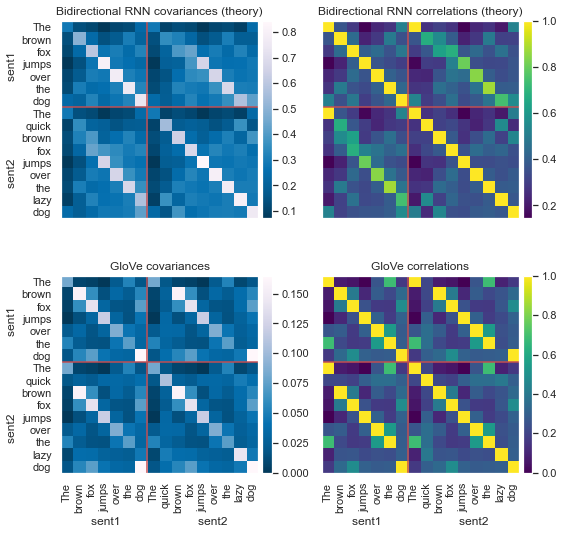

In [7]:
from utils import getCor, colorbar

plt.figure(figsize=(8, 8))

plt.subplot(221)
ax = plt.gca()
im_thcov = plt.imshow(thcov, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks([])
plt.title('Bidirectional RNN covariances (theory)')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_thcov)

plt.subplot(222)
ax = plt.gca()
im_thcor = plt.imshow(getCor(thcov), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks([])
plt.title('Bidirectional RNN correlations (theory)')
plt.grid()
colorbar(im_thcor)


plt.subplot(223)
ax = plt.gca()
im_glove = plt.imshow(exampleGloveCov, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe covariances')
plt.xlabel('sent1                       sent2')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_glove)

plt.subplot(224)
ax = plt.gca()
im_glovecor = plt.imshow(getCor(exampleGloveCov), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe correlations')
plt.xlabel('sent1                       sent2')
plt.grid()
colorbar(im_glovecor)

plt.tight_layout()

In [8]:
with open(f'BiRNN{mergemode}.kernel', 'wb') as f:
    np.save(f, thcov)

# Verifying Theory with Simulation

We randomly initialize 100 bidirectional RNNs for each width among $[2^5, 2^6, \ldots, 2^{13}]$ and run them on the two sentences above.
We calculate the empirical Gram matrix of the RNN embeddings (stored in `mysimcovs`) as well as its Frobenius distance to the infinite-width theoretical kernel `thcov` (stored in `frobs`)

In [9]:
from BiRNNsim import simbirnn

In [10]:
nsamples = 100
widths = [2**i for i in range(5, 13)]
mysimcovs = {}
for width in widths:
    mysimcovs[width] = np.array([
        simbirnn([exampleGloveVecs[:7], exampleGloveVecs[7:]], width, F.erf, mergemode, varw, varu, varb, seed=seed)[1]
        for seed in range(nsamples)])
frobs = []
for width in widths:
    _frobs = np.sum((mysimcovs[width] - thcov)**2, axis=(1, 2)) / np.linalg.norm(thcov)**2
    for f in _frobs:
        frobs.append(dict(
            relfrob=f,
            width=width
        ))

We store the relative Frobenius distances in a `DataFrame`.

In [11]:
frob_df = pd.DataFrame(frobs)

In [12]:
frob_df.to_pickle(f'BiRNN{mergemode}.df')

The deviation from infinite-width theory drops with width, as expected.

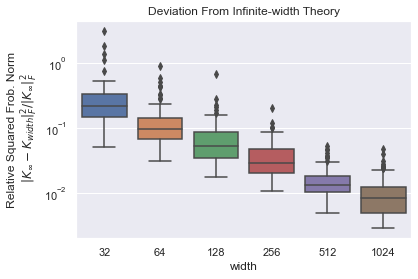

In [13]:
sns.boxplot(x='width', y='relfrob', data=frob_df)
plt.semilogy()
# plt.legend()
plt.title('Deviation From Infinite-width Theory')
_ = plt.ylabel(u'Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')

The deviation from theory in *squared* Frobenius norm scales like $\frac{1}{width}$ (so, in Frobenius norm, the deviation scales like $width^{-1/2}$).

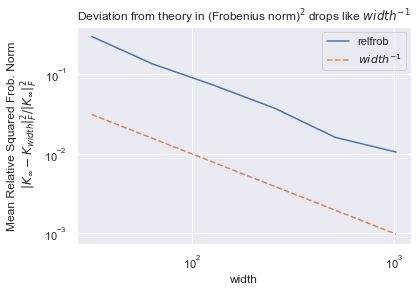

In [14]:
frob_df.groupby('width', as_index=False).mean().plot.line(x='width', y='relfrob')
plt.plot(widths, np.array(widths, dtype='float')**-1, '--', label=u'${width}^{-1}$')
plt.ylabel(u'Mean Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.loglog()
plt.legend()
_ = plt.title(u'Deviation from theory in (Frobenius norm)$^2$ drops like $width^{-1}$')